# Optimization
<style type="text/css">
  .reveal p {
    text-align: left;
  }
  .reveal ul {
    display: block;
  }
  .reveal ol {
    display: block;
  }
</style>

In [1]:
using Gadfly 
set_default_plot_size(12inch, 6inch) #set size
#make lines and points thicker and bigger labels
Gadfly.push_theme(Theme(major_label_font_size=20pt,minor_label_font_size=14pt,key_label_font_size=16pt,
                        line_width=2pt,point_size=3pt))

## Introduction

*  In economics we often find our selves needing to maximize some objective function

* i.e. solve a problem of the form
$$
    \max_{\mathbf x} f(\mathbf x)
$$subject to 
\begin{align*}
    g_i(\mathbf x)&\leq 0\\
    r_j(\mathbf x)&= 0
\end{align*}

* Well begin by looking at 
$$
    \min_{\mathbf x} f(\mathbf x)
$$

## Isomorphism 
* Start with the standard minimization problem
$$
    \min_{\mathbf x} f(\mathbf x)
$$

* If concave, this is isomorphic to the root-solving problem
$$
    \nabla f(\mathbf x) = 0
$$

*  The multivariate root-finding problem 
$$
    g^i(\mathbf x) = 0
$$ can be recast as
$$
    \min_{\mathbf x} \sum_i g^i(\mathbf x)^2
$$

## Basic Concepts
* All methods: *Search the space of feasible choices by generating a sequence of guesses that (hopefully) converges to a solution.*

* Essentially two types:
    * **Comparison Methods:** Compute objective at valious points, find the one which gives smallest value
    * **Gradient Based Methods:**  Use information on the slope (and possibly hessian!)

* All these methods will find **local** minima.  
    * Not a problem if you minimization problem is convex

* If not, need multiple initializations to be sure a global minimum is found
    * Note: can do this after value function has converged if used in dynamic optimzation.

## How to Choose an Algorithm

* **Speed:**  Optimization is likely goiong to be in the innermost loop

    * Want a fast algorithm: i.e. minimizes number of function evaluations

    * Gradient Based methods generally involve fewer evaluations

* **Robustness to Nonsmoothness:**  If you objective function is not smooth gradient based methods will have difficulty, can get stuck 

    * Comparison methods are generally better behaved

* **Robustness to starting parameters:**  Gradient based are also more likely to find different local minima at different starting values

    * Stochastic comparison methods (like simulated annealing) are more likely to find global minima

## Bracketing Method
* Similar to Brent root search algorithm

    * Most reliable method for one dimensional problems

    * Guaranteed to find local minima for continuous functions

* Initialization: Choose triple $(a,b,c)$ such that $a<b<c$ and  $f(a),f(c) >f(b)$

    * Note this implies there must be a local minima in $[a,c]$

* Choose $d\in(a,b)$

    * If $f(d) > f(b)$ then there is a minima in $[d,c]$ choose new triple $(d,b,c)$

    * If $f(d) < f(b)$ then there is a minima in $[a,b]$ choose new triple $(a,d,b)$

* Update the triple $(a,b,c)$ to the new one in previous step

* Stop if $c-a <\delta$

* **Golden Search** provides optimal way to choose $b,d$

## Example function

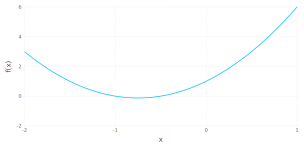

In [2]:
using Optim #Our optimization libarary
using Gadfly
f_univ(x) = 2x^2+3x+1
plot(f_univ,-2.,1)

## Using Optim Univariate

In [3]:
#Finds global minimum
res = optimize(f_univ,-2.0,1.0,GoldenSection())
Optim.minimizer(res)

-0.749999994377939

In [4]:
#Lower bound binds
res = optimize(f_univ,-0.5,1.0,GoldenSection())
Optim.minimizer(res)

-0.49999998939347085

## Brent's Method

* An alternative to choosing $d$ through golden search

* Construct a quadratic polynomial that fits values for points $(a,b,c)$

* Let $d$ be the point that minimizes that polynomial

    * Use criteria from above to choose new tuple $(d,b,c)$ or $(a,d,c)$

* Can lead to significantly faster convergence

In [5]:
optimize(f_univ,-2.0,1.0,Brent()) #run once to precompile
@time res = optimize(f_univ,-2.0,1.0,Brent());

  0.000003 seconds (2 allocations: 176 bytes)


In [6]:
@time res = optimize(f_univ,-2.0,1.0,GoldenSection());

  0.000003 seconds (2 allocations: 176 bytes)


# Multivariate Optimization

## Simplex Methods
* This provides a algorithm to extend derivative free methods to $n$ dimensions
* Start with $n+1$ points $\mathbf x_1,\mathbf x_2,\ldots,\mathbf x_{n+1}$
    * Ordered such that $f(\mathbf x_1)\leq f(\mathbf x_2)\leq\ldots\leq f(\mathbf x_{n+1})$
* Perform the following operations: Reflection, Expansion, Contraction and Shrinkage

1. Order points of simplex by $f$ and calculate centroid $\mathbf x_0$ of all points but $\mathbf x_{n+1}$
2. **Reflection:** Compute the reflected point $\mathbf x_r = \mathbf x_0 + \alpha (\mathbf x_0 -\mathbf x_{n+1})$
    * If $f(\mathbf x_1)\leq f(\mathbf x_r)<f (\mathbf x_n)$: return to 1. with $\mathbf x_{n+1} = \mathbf x_r$
3. **Expansion:** If $f(\mathbf x_r)<f(\mathbf x_1)$ construct $\mathbf x_e = \mathbf x_0 + \gamma (\mathbf x_r -\mathbf x_0)$
    * If $f(\mathbf x_r)\leq f(\mathbf x_e))$: return to 1. with $\mathbf x_{n+1} = \mathbf x_r$
    * If $f(\mathbf x_e)\leq f(\mathbf x_r))$: return to 1. with $\mathbf x_{n+1} = \mathbf x_e$
4. **Contracation:** Now $f(\mathbf x_r)\geq f(\mathbf x_n)$, construct $\mathbf x_c = \mathbf x_0 + \rho(\mathbf x_{n+1}-\mathbf x_0)$
    * If $f(\mathbf x_c) < f(\mathbf x_{n+1})$ return to 1. with $\mathbf x_{n+1} = \mathbf x_c$
5. **Shrink:** for $i\geq 2$ replace $\mathbf x_i = \mathbf x_1 + \sigma (\mathbf x_i - \mathbf x_1)$ go to step 1

Standard values $\alpha = 1.$, $\gamma = 2$, $\rho = 0.5$, and $\sigma = 0.5$

## Reflection, Expansion, Contraction etc. 
![](assets/simplex_animation.gif)

## Example
![](assets/Nelder-Mead_Rosenbrock.gif)

## Example Code

In [7]:
#rosenbrock function
f_ros(x) = (1.0 - x[1])^2 + 100.0 * (x[2] - x[1]^2)^2
optimize(f_ros,10*ones(2),NelderMead())

 * Status: success

 * Candidate solution
    Final objective value:     3.950131e-09

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    103
    f(x) calls:    198


In [8]:
#uses by default AffineSimplexer()
Optim.simplexer(Optim.AffineSimplexer(),[0.,1.]);

## Simulated Annealing
* Very helpful if you need to find global minimum of a function which is plagued a lot of local minima

* Algorithm (start from guess $\mathbf x_0$):

    1. Draw $\mathbf z$ from standard multivariate normal 
    $$
        \mathbf x_1 = \mathbf x_0 + \lambda \mathbf z 
    $$

    2. Accept $x_1$ if $f(\mathbf x_1)< f(\mathbf x_0)$ or with probability
    $$
        \exp\left(-\frac{f(\mathbf x_1)-f(\mathbf x_0)}{T}\right)
    $$ $T$ is called the temperature

    3. Go back to step 1 with $x_0 = x_1$

    4. Reduce $T$ after each iteration, stop after $n_{max}$ iterations

![](assets/Simulated_Annealing.gif)

## Code implementation

In [9]:
#Simulated Annealing
result = optimize(f_ros,zeros(2),SimulatedAnnealing(),Optim.Options(iterations=10^7)) #very rough right now

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     4.351665e-06

 * Found with
    Algorithm:     Simulated Annealing

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 1.0e-08

 * Work counters
    Seconds run:   3  (vs limit Inf)
    Iterations:    10000000
    f(x) calls:    10000001


In [10]:
#Obtaining solutions
println("Value of Function at Minimum:$(result.minimum)")
println("Point that Acheives Minimum:$(result.minimizer)")

Value of Function at Minimum:4.351665335211619e-6
Point that Acheives Minimum:[0.9988381063649525, 0.9975043094867531]


# Gradient Based Methods
## Newton's Method

* Very similar to Newton's Rootfinding method

* Do a second order taylor expansion around $x_n$
$$
f(x) \approx f(x_n) + f'(x^n)(x-x^n) + \frac12 f''(x^n)(x-x^n)^2
$$

* Minimizing this approximated function (taking the first order condition) to get
$$
    x_{n+1} = x_n - \frac{f'(x_n)}{f''(x_n)}
$$

* Need both first and second derivatives

* **Note:** $f''(x_n)$ determines how far you move in the direction $f'(x_n)$, will move in the direction that decreases $f$ to first order as long as $f''(x_n) > 0$

## Multivariate Extension
* For a multivariate function $f(\mathbf x)$ the second order Taylor expansion is
$$
    f(\mathbf x) \approx f(\mathbf x_n) + \nabla f(\mathbf x_n)(\mathbf x-\mathbf x_n) + \frac12 (\mathbf x-\mathbf x_n)' H(\mathbf x_n)(\mathbf x-\mathbf x_n)
$$

* This yields an updating equation
$$
    \mathbf x_{n+1} = \mathbf x_n - H(\mathbf x_n)^{-1} \nabla f(\mathbf x_n)
$$

* Problem: Computing $H$ can be time consuming

    * May also not be positive definite (can result in algorithm moving in wrong direction (i.e. towards max)

## Quasi-Newton Methods

* Approximate the Hessian with a positive definite matrix

* Example: set Hessian to $I$
$$
    \mathbf x_{n+1} = \mathbf x_{n} -\nabla f(\mathbf x_n)
$$

    * Always moves in the right direction but can overshoot, slow convergence rate

* BFGS algorithm uses secant to approximate the Hessisan

    * Starts with Hessian being $I$, updates it by using changes in the gradient
    
    * Can show that approximated Hessian will remain Positive definite


## Implementation

In [11]:
optimize(f_ros,zeros(2),BFGS())

 * Status: success

 * Candidate solution
    Final objective value:     5.471433e-17

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 3.47e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.47e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.59e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.20e+03 ≰ 0.0e+00
    |g(x)|                 = 2.33e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    16
    f(x) calls:    53
    ∇f(x) calls:   53


In [12]:
@time optimize(f_ros,zeros(2),NelderMead())
@time optimize(f_ros,zeros(2),SimulatedAnnealing(),Optim.Options(iterations=10^7))
@time optimize(f_ros,zeros(2),BFGS());

  0.000066 seconds (342 allocations: 9.406 KiB)
  2.799352 seconds (20.00 M allocations: 305.177 MiB, 2.55% gc time)
  0.000098 seconds (608 allocations: 25.984 KiB)


# Problems With Constraints

* Many times we will wish to perform the following kind of maximization
$$
    \max_{\mathbf x} f(\mathbf x)
$$subject to 
\begin{align*}
    g_i(\mathbf x)&\leq 0\\
    r_j(\mathbf x)&= 0
\end{align*}

* Construct a penalty function for violating the constraints
$$
    P(\mathbf x) = \sum_{i=1}^m[\max\{0,g_i(\mathbf x)\}]^2 + \sum_{j=1}^k [r_j(\mathbf x)]^2
$$

* Create a new objective function
$$
    h(c,\mathbf x) = f(\mathbf x)+cP(\mathbf x)
$$

## Augmented Lagrangian Technique
* Start with a relatively small value of $c$ and an initial point $\mathbf x$

* Solve a sequence of problems with monotonically increasing values of $c$

    1. Choose a growth parameter $\eta>1$ and initial penalty $c^0$

    2. At iteration $n$ minimize $h(c_n,\mathbf x)$.  Call this solution $\mathbf x_n$.  If $\mathbf x_n$ does not violate constraints more than $\epsilon$ then stop.  Otherwise $c_{n+1}  = (1+\eta)c_n$ and repeat starting from $\mathbf x_n$

* Can show that this will work as long as such a mininum exists

## Example
![](assets/NLopt-example.png)

## Example Code

In [13]:
using NLopt
function myfunc!(x::Vector, grad::Vector)
    if length(grad) > 0
        grad[1] = 0
        grad[2] = 0.5/sqrt(x[2])
    end

    sqrt(x[2])
end

function myconstraint!(x::Vector, grad::Vector, a, b)
    if length(grad) > 0
        grad[1] = 3a * (a*x[1] + b)^2
        grad[2] = -1
    end
    (a*x[1] + b)^3 - x[2]
end

myconstraint! (generic function with 1 method)

## Example Code MMD Algorithm

In [14]:
opt = Opt(:LD_MMA, 2)
lower_bounds!(opt, [-Inf, 0.])
ftol_rel!(opt,1e-6)

min_objective!(opt, myfunc!)
inequality_constraint!(opt, (x,g) -> myconstraint!(x,g,2,0))
inequality_constraint!(opt, (x,g) -> myconstraint!(x,g,-1,1))

(minf,minx,ret) = NLopt.optimize(opt, [3., 1.])
println("got $minf at $minx after $count iterations (returned $ret)")

got 0.5443310582637382 at [0.333333330123988, 0.2962963009905211] after count iterations (returned FTOL_REACHED)


## Example Code SLSQP Algorithm

In [15]:
opt = Opt(:LD_SLSQP, 2)
lower_bounds!(opt, [-Inf, 0.])
ftol_rel!(opt,1e-4)

min_objective!(opt, myfunc!)
inequality_constraint!(opt, (x,g) -> myconstraint!(x,g,2,0))
inequality_constraint!(opt, (x,g) -> myconstraint!(x,g,-1,1))

(minf,minx,ret) = NLopt.optimize(opt, [3., 1.])
println("got $minf at $minx after $count iterations (returned $ret)")

got 0.5443310809303847 at [0.3333333211928888, 0.296296325666841] after count iterations (returned FTOL_REACHED)


# Application: Optimal Taxation
## Mirelees Meets Ramsey (Heathcote et. al 2016)
* Economy is populated by a continuum of agents
    * Preferences $U(c,h) = \frac{c^{1-\sigma}}{1-\sigma}-\frac{h^{1+\gamma}}{1+\gamma}$
    * Output produced linearly with productivity $\exp(\alpha)$
* Log productivity $\alpha$
    * $\alpha\sim\mathcal N(-\sigma_\alpha^2/2,\sigma_\alpha)$
* Government chooses tax policy $T(y) = \tau y - T$ 

## Agent's Problem
* Agents are indexed by their productivity type $\alpha$
* Solve the following problem
$$
    \max_{c,h\geq 0} \frac{c^{1-\sigma}}{1-\sigma}-\frac{h^{1+\gamma}}{1+\gamma}
$$subject to
$$
    c = (1-\tau)\exp(\alpha)h + T
$$
* Optimal policies $c(\alpha;\tau,T)$ and $h(\alpha;\tau,T)$ give utility $U(\alpha;\tau,T)$

## Government's Problem
* Government has utilitarian preferences:
$$
    \int U(\alpha;\tau,T)dF(\alpha)
$$
* Chooses $\tau$ and $T$ to maximize this objective subject to the governments budget constraint
$$
    T = \int \tau \exp(\alpha)h(\alpha;\tau,T)dF(\alpha)
$$

## Computing Consumption and Hours
* Household first order condition
$$
    h^\gamma = c^{-\sigma} (1-\tau)\exp(\alpha)
$$
* Combine with budget constraint:
$$
    h^\gamma = \left((1-\tau)\exp(\alpha)h+T\right)^{-\sigma}(1-\tau)\exp(\alpha)
$$
* To compute $h(\alpha;\tau,T)$, find root of 
$$
     \left((1-\tau)\exp(\alpha)h+T\right)^{-\sigma}(1-\tau)\exp(\alpha) - h^\gamma
$$


## Implementation

* A lot of layers to this problem

* Start by building up basic components: household decisions

In [16]:
using Roots
"""
    household_labor(α,τ,T,σ,γ)

Solves for HH labor choice given policy and preferences
"""
function household_labor(α,τ,T,σ,γ)
    Ŵ = (1-τ)*exp(α) #after tax wages
    res(h) = (Ŵ*h+T)^(-σ)*Ŵ-h^γ
    min_h = max(0,(.0000001-T)/(1-τ)*exp(α)) #ensures c>.0001
    h = fzero(res,min_h,20000.) #find hours that solve HH problem
    c = Ŵ+T
    U = c^(1-σ)/(1-σ)-h^(1+γ)/(1+γ)
    return c,h,U
end

household_labor

## Implementation Cont.

* Next we can aggregate to check Govt. Budget Constraint

In [17]:
"""
    budget_residual(τ,T,αvec,σ,γ)

Computes the residual of the HH budget constraint given policy (τ,T).
αvec contains the vector of α values for each agent
"""
function budget_residual(τ,T,αvec,σ,γ)
    tax_income = 0.
    N = length(αvec)
    for i in 1:N
        c,h,U = household_labor(αvec[i],τ,T,σ,γ)
        tax_income += τ*h*exp(αvec[i])
    end
    return tax_income/N - T
end

budget_residual

## Implementation Cont.
* Finally we can compute welfare for a given choice of tax rate

In [18]:
"""
    government_welfare(τ,αvec,σ,γ)

Solves for government welfare given tax rate τ
"""
function government_welfare(τ,αvec,σ,γ)
    f(T) = budget_residual(τ,T,αvec,σ,γ)
    T =  fzero(f,0.) #Find transfers that balance budget
    
    welfare = 0.
    N = length(αvec)
    for i in 1:N
        #compute HH welfare given tax rate
        c,h,U = household_labor(αvec[i],τ,T,σ,γ)
        welfare += U #Aggregate welfare
    end
    return welfare/N
end

government_welfare

## Calibration

In [19]:
using Distributions
σ = 2. #Standard
γ = 2. #Targets Frisch elasticity of 0.5
σ_α = sqrt(0.147) #Taken from HSV
N = 1000
alphaDist = Normal(-σ_α^2/2,σ_α)
αvec = rand(alphaDist,N);

## Welfare Function

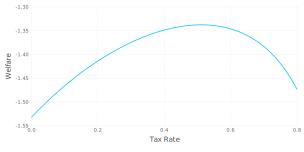

In [20]:
plot(τ->government_welfare(τ,αvec,σ,γ),0.,0.8,Guide.ylabel("Welfare"),Guide.xlabel("Tax Rate"))

## Optimization

In [21]:
Optim.optimize(τ->-government_welfare(τ,αvec,σ,γ),0.,0.8)

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [0.000000, 0.800000]
 * Minimizer: 5.118991e-01
 * Minimum: 1.337548e+00
 * Iterations: 13
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 14